#### Confounding variable analysis

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [3]:
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

In [100]:
# Let's look at individual trainer scores first 

indiv_df = df[['subject_id', 'user_name', 'foraging_performance', 'session_date']]

scaler = StandardScaler()

indiv_df['foraging_performance_scaled'] = scaler.fit_transform(indiv_df[['foraging_performance']])

indiv_df.head()

/tmp/ipykernel_6194/1777606908.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['foraging_performance_scaled'] = scaler.fit_transform(indiv_df[['foraging_performance']])


,subject_id,user_name,foraging_performance,session_date,foraging_performance_scaled
0,730942,Bowen Tan,0.748154,2024-09-10,0.989272
1,741211,Bowen Tan,0.760353,2024-09-10,1.072642
2,736198,Bowen Tan,0.700040,2024-09-10,0.660454
3,730945,Bowen Tan,0.557400,2024-09-10,-0.314376
4,741213,Bowen Tan,0.738699,2024-09-10,0.924653


In [101]:
ra_pivot_table = indiv_df.pivot_table(values='foraging_performance_scaled', index='user_name', columns='subject_id')

ra_pivot_table = ra_pivot_table.fillna(0)

In [102]:
ra_pivot_table.head(20)

subject_id,662914,663612,668463,668546,668548,668551,671087,676746,676747,680396,...,747313,747315,750101,750102,750107,750108,753122,753124,753125,753126
user_name,,,,,,,,,,,,,,,,,,,,,
Avalon Amaya,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Bowen Tan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.908963,-0.665976,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Bowen Tanl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Ella Hilton,1.574224,0.000000,0.000000,0.500388,0.000000,-0.479663,0.000000,0.000000,-1.905795,-0.052494,...,0.000000,0.000000,-0.399876,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Galen Lynch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Henry Loeffer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Henry Loeffler,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.721472,0.000000,0.00000,0.000000,0.000000,0.000000
Huy Nguyen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.361043,0.000000,-0.550318,0.17986,0.000000,0.000000,0.000000
Jaimie Kenney,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


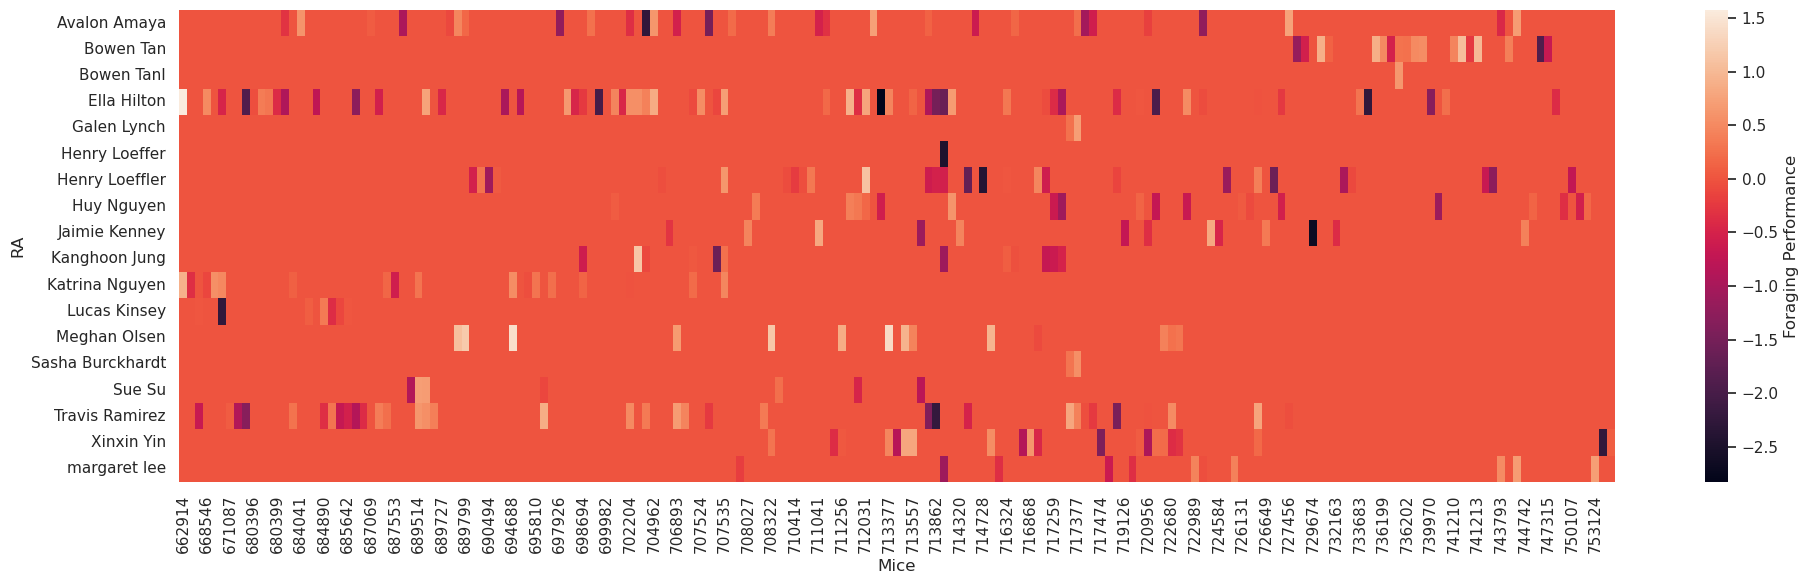

In [103]:
sns.set_theme()

plt.figure(figsize=(20,6))
sns.heatmap(ra_pivot_table, cbar_kws={'label': 'Foraging Performance'})
plt.xlabel('Mice')
plt.ylabel('RA')

plt.tight_layout()

plt.show()

In [104]:
# Create consistency df

indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])

indiv_df = indiv_df.drop_duplicates(['subject_id', 'user_name', 'session_date'])

# Group by subject_id and user_name then calculate consistency (# trained sessions/total date range)
consistency_df = indiv_df.groupby(['subject_id', 'user_name']).agg({
    'session_date': lambda x: (x.max() - x.min()).days + 1,  # Total date range in days
    'foraging_performance': 'count'  # Number of training days
}).reset_index()

# Rename columns
consistency_df.columns = ['subject_id', 'user_name', 'date_range', 'training_days']

# Calculate consistency
consistency_df['training_consistency'] = consistency_df['training_days'] / consistency_df['date_range']
consistency_df['training_consistency_percentage'] = consistency_df['training_consistency'] * 100

# Scale consistency 

consistency_df['training_consistency_scaled'] = scaler.fit_transform(consistency_df[['training_consistency']])

consistency_df.head()

/tmp/ipykernel_6194/4123435518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])


,subject_id,user_name,date_range,training_days,training_consistency,training_consistency_percentage,training_consistency_scaled
0,662914,Ella Hilton,4,4,1.000000,100.000000,1.486170
1,662914,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827
2,663612,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827
3,668463,Lucas Kinsey,50,23,0.460000,46.000000,-0.872007
4,668463,Travis Ramirez,5,3,0.600000,60.000000,-0.260628


In [105]:
subject = 662914

new_df = consistency_df[consistency_df['subject_id'] == subject].copy()

new_df.head()

,subject_id,user_name,date_range,training_days,training_consistency,training_consistency_percentage,training_consistency_scaled
0,662914,Ella Hilton,4,4,1.000000,100.000000,1.486170
1,662914,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827


In [106]:
subject = 662914

new1_df = indiv_df[indiv_df['subject_id'] == subject].copy()

new1_df.head(20)

,subject_id,user_name,foraging_performance,session_date,foraging_performance_scaled
3587,662914,Ella Hilton,0.855671,2023-10-06,1.724061
3599,662914,Ella Hilton,0.707710,2023-10-05,0.712867
3609,662914,Ella Hilton,0.801757,2023-10-04,1.355604
3619,662914,Ella Hilton,0.969848,2023-10-03,2.504366
3625,662914,Katrina Nguyen,0.784814,2023-09-29,1.239811
3643,662914,Katrina Nguyen,0.660714,2023-09-25,0.391693
3648,662914,Katrina Nguyen,0.830616,2023-09-22,1.552828
3658,662914,Katrina Nguyen,0.782875,2023-09-21,1.226557
3663,662914,Katrina Nguyen,0.629848,2023-09-19,0.180746


In [107]:
consistency_pivot_table = consistency_df.pivot_table(values='training_consistency_scaled', index='user_name', columns='subject_id')

consistency_pivot_table = consistency_pivot_table.fillna(0)

In [108]:
consistency_pivot_table.head(20)

subject_id,662914,663612,668463,668546,668548,668551,671087,676746,676747,680396,...,747313,747315,750101,750102,750107,750108,753122,753124,753125,753126
user_name,,,,,,,,,,,,,,,,,,,,,
Avalon Amaya,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Bowen Tan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.48617,1.48617,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Bowen Tanl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Ella Hilton,1.486170,0.000000,0.000000,1.486170,0.000000,1.486170,0.000000,0.000000,-0.260628,-0.697327,...,0.00000,0.00000,-0.122723,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Galen Lynch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Henry Loeffer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Henry Loeffler,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.238457,0.00000,0.000000,0.000000,0.000000,0.000000
Huy Nguyen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,-0.352565,0.000000,1.48617,-0.352565,0.000000,0.000000,0.000000
Jaimie Kenney,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


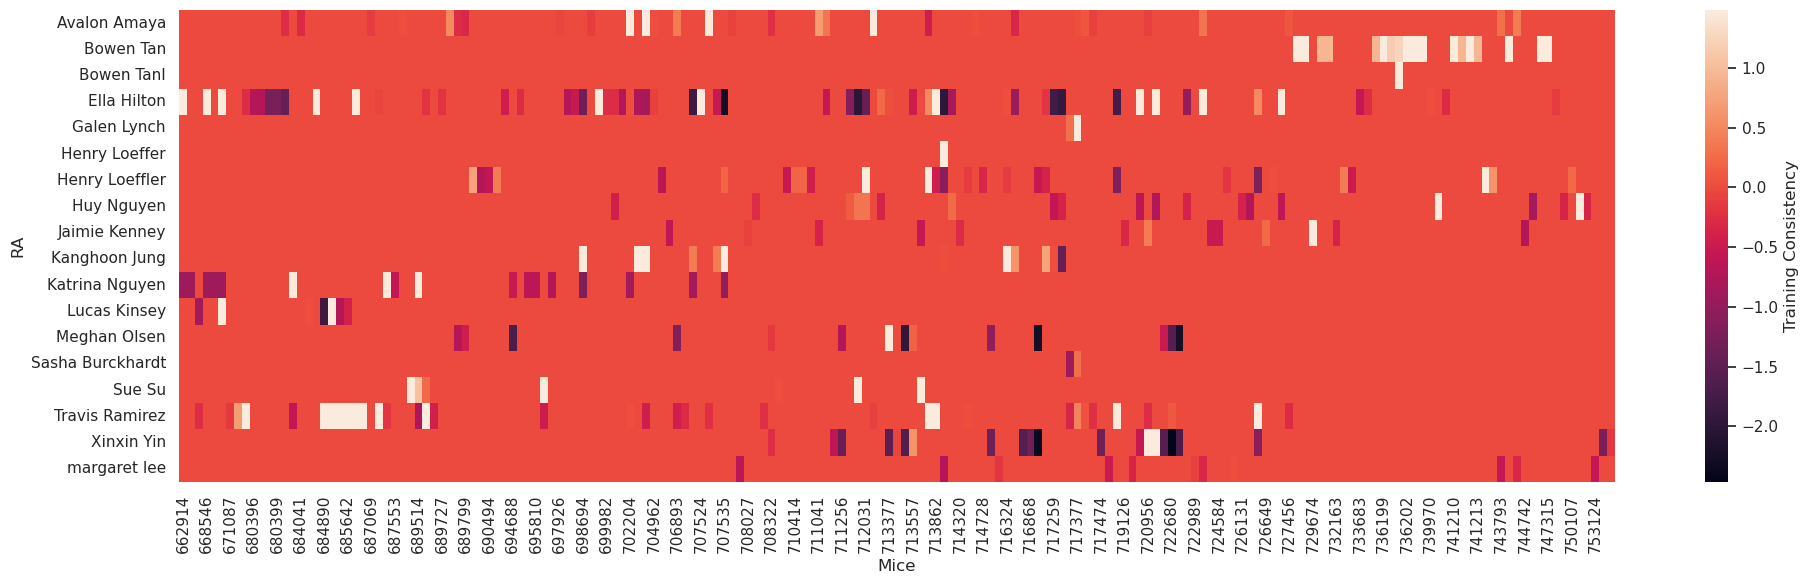

In [109]:
plt.figure(figsize=(20,6))
sns.heatmap(consistency_pivot_table, cbar_kws={'label': 'Training Consistency'})
plt.xlabel('Mice')
plt.ylabel('RA')

plt.tight_layout()

plt.show()

In [110]:
# Correlation analysis

flattened_ra_fp = ra_pivot_table.values.flatten()
flattened_ra_cons = consistency_pivot_table.values.flatten()

correlation_cons_fp = pd.Series(flattened_ra_fp).corr(pd.Series(flattened_ra_cons))
print(f'Correlation: {correlation_cons_fp}')

Correlation: -0.16913036602236087


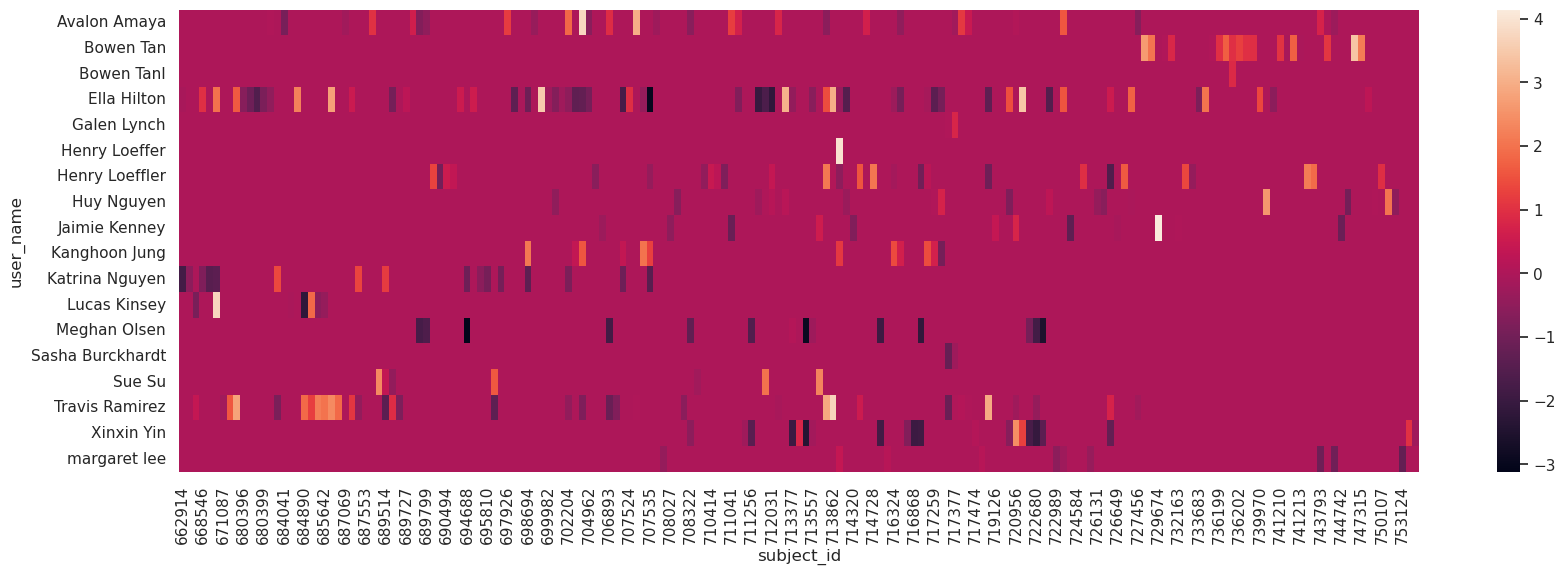

In [111]:
difference = consistency_pivot_table - ra_pivot_table

plt.figure(figsize=(20,6))
sns.heatmap(difference)
plt.show()

In [112]:
# Look at cross-talk 

total_ras = len(ra_pivot_table.index)
total_mice = len(ra_pivot_table.columns)

mice_trained_by_multiple = (ra_pivot_table > 0).sum(axis=0) > 1
ras_training_multiple = (ra_pivot_table > 0).sum(axis=1) > 1

print(f"Total analysts: {total_ras}")
print(f"Total mice: {total_mice}")
print(f"Mice trained by multiple analysts: {mice_trained_by_multiple.sum()} ({mice_trained_by_multiple.sum()/total_mice:.2%})")
print(f"Analysts training multiple mice: {ras_training_multiple.sum()} ({ras_training_multiple.sum()/total_ras:.2%})")

# Average number of mice per analyst and analysts per mouse
avg_mice_per_ra = (ra_pivot_table > 0).sum(axis=1).mean()
avg_ra_per_mouse = (ra_pivot_table > 0).sum(axis=0).mean()

print(f"\nAverage number of mice per analyst: {avg_mice_per_ra:.2f}")
print(f"Average number of analysts per mouse: {avg_ra_per_mouse:.2f}")

Total analysts: 18
Total mice: 183
Mice trained by multiple analysts: 35 (19.13%)
Analysts training multiple mice: 16 (88.89%)

Average number of mice per analyst: 8.44
Average number of analysts per mouse: 0.83


In [115]:
indiv_df.head()

,subject_id,user_name,foraging_performance,session_date,foraging_performance_scaled
0,730942,Bowen Tan,0.748154,2024-09-10,0.989272
1,741211,Bowen Tan,0.760353,2024-09-10,1.072642
2,736198,Bowen Tan,0.700040,2024-09-10,0.660454
3,730945,Bowen Tan,0.557400,2024-09-10,-0.314376
4,741213,Bowen Tan,0.738699,2024-09-10,0.924653


In [116]:
corr_df = consistency_df.copy()

corr_df['scaled_foraging_performance'] = indiv_df[['foraging_performance_scaled']]

cat_df = corr_df.copy()

mice_trained_by_multiple_df = pd.DataFrame({
    'subject_id': ra_pivot_table.columns,
    'mice_trained_by_multiple': mice_trained_by_multiple.values
})

cat_df = cat_df.merge(mice_trained_by_multiple_df, on='subject_id', how='left')

cat_df.head(20)

,subject_id,user_name,date_range,training_days,training_consistency,training_consistency_percentage,training_consistency_scaled,scaled_foraging_performance,mice_trained_by_multiple
0,662914,Ella Hilton,4,4,1.000000,100.000000,1.486170,0.989272,True
1,662914,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827,1.072642,True
2,663612,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827,0.660454,False
3,668463,Lucas Kinsey,50,23,0.460000,46.000000,-0.872007,-0.314376,False
4,668463,Travis Ramirez,5,3,0.600000,60.000000,-0.260628,0.924653,False
5,668546,Ella Hilton,4,4,1.000000,100.000000,1.486170,-0.421373,False
6,668546,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827,-1.163089,False
7,668548,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827,0.398872,False
8,668551,Ella Hilton,4,4,1.000000,100.000000,1.486170,-0.541312,False
9,668551,Katrina Nguyen,11,5,0.454545,45.454545,-0.895827,0.453522,False


<Figure size 2000x600 with 0 Axes>

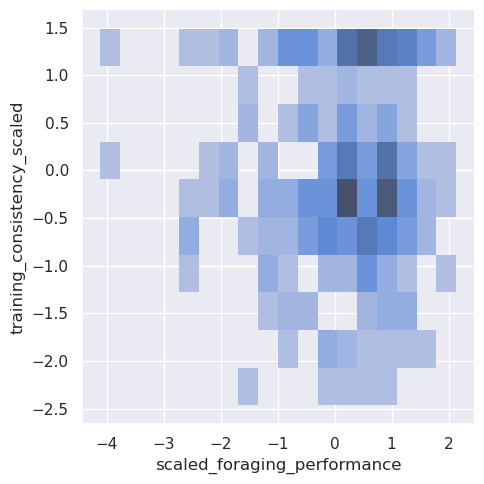

In [117]:
plt.figure(figsize=(20,6))
sns.displot(data=cat_df, x='scaled_foraging_performance', y='training_consistency_scaled')

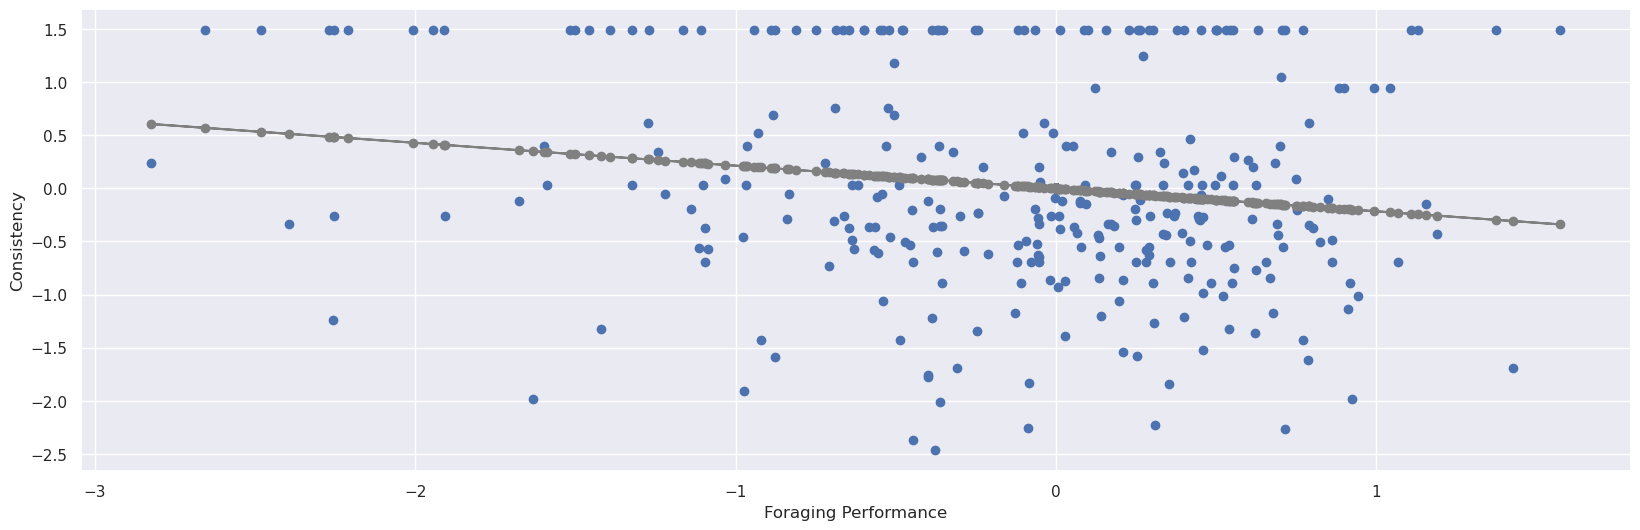

R squared: 0.02860508071085776


In [118]:
slope, intercept, r_value, p_value, std_err = stats.linregress(flattened_ra_fp, flattened_ra_cons)

plt.figure(figsize=(20,6))
plt.scatter(flattened_ra_fp, flattened_ra_cons)
plt.plot(flattened_ra_fp, slope * flattened_ra_fp + intercept, color='grey', marker='o')
plt.xlabel('Foraging Performance')
plt.ylabel('Consistency')
plt.show()

print(f'R squared: {r_value**2}')

<Figure size 2000x1000 with 0 Axes>

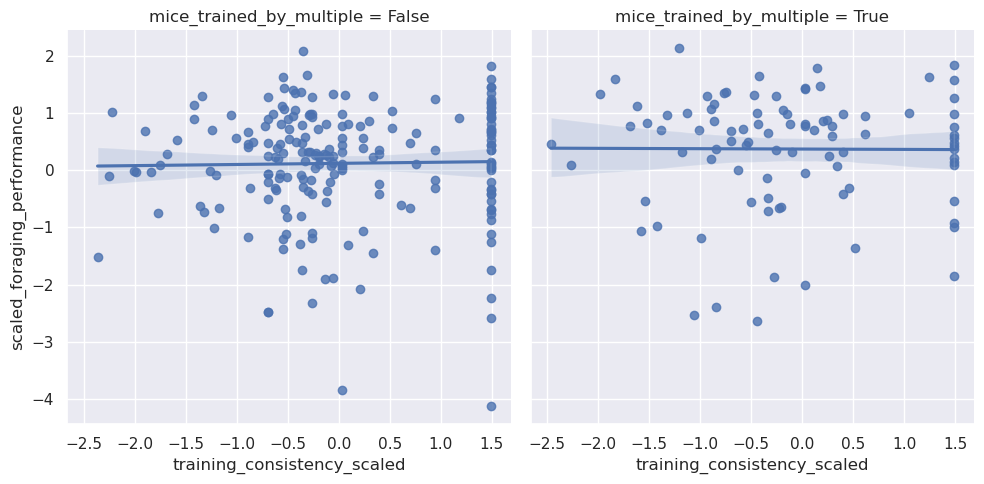

In [119]:

plt.figure(figsize=(20,10))
sns.lmplot(data=cat_df, x='training_consistency_scaled', y='scaled_foraging_performance', col='mice_trained_by_multiple')

<Axes: xlabel='scaled_foraging_performance', ylabel='training_consistency_scaled'>

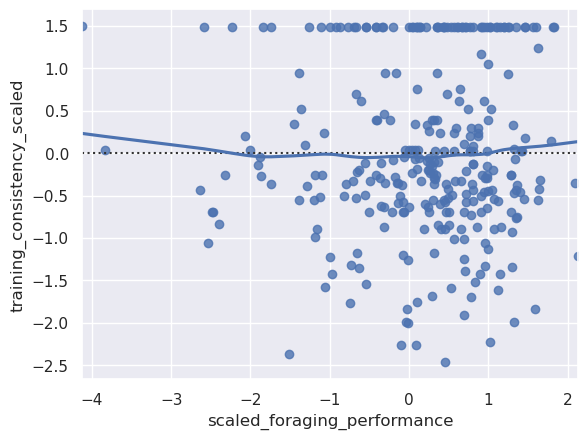

In [120]:
sns.residplot(data=cat_df, x='scaled_foraging_performance', y='training_consistency_scaled', lowess=True)

<Axes: xlabel='training_consistency_scaled', ylabel='scaled_foraging_performance'>

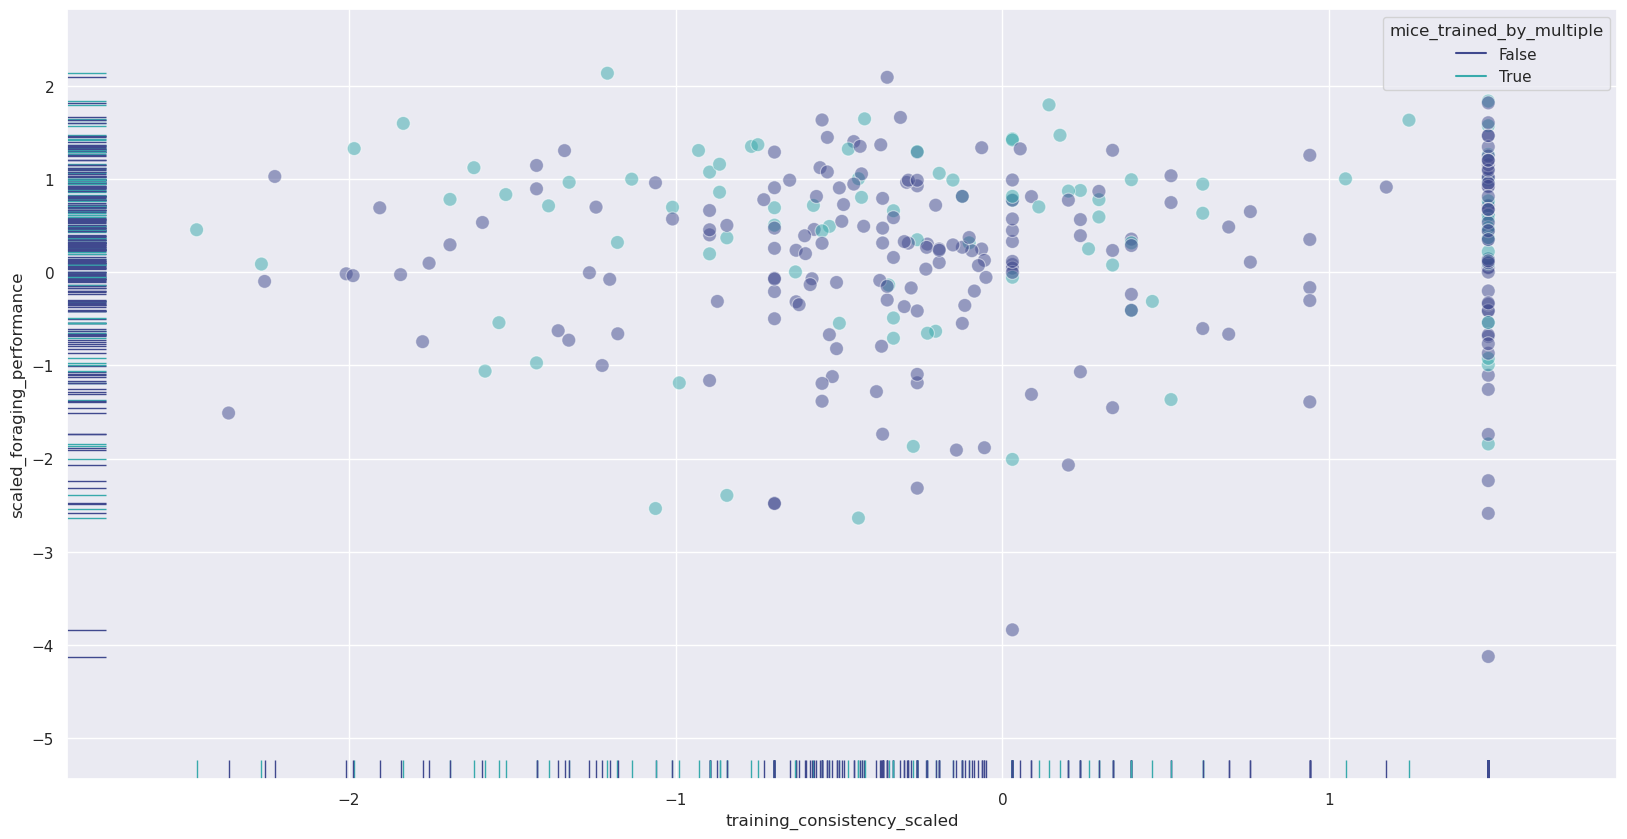

In [121]:

plt.figure(figsize=(20,10))
sns.scatterplot(data=cat_df, x='training_consistency_scaled', y='scaled_foraging_performance', hue='mice_trained_by_multiple', s=100, alpha=0.5, palette='mako')
sns.rugplot(data=cat_df, x='training_consistency_scaled', y='scaled_foraging_performance', hue='mice_trained_by_multiple', palette='mako', clip_on=True)

In [18]:
# Create mask for mouse-RA interactions: DOES NOT WORK

unique_interactions = ~(ra_pivot_table.index.to_series().isin(ras_training_multiple[ras_training_multiple].index) & 
                        ra_pivot_table.columns.to_series().isin(mice_trained_by_multiple[mice_trained_by_multiple].index))

unique_ra_pivot_table = ra_pivot_table.where(unique_interactions, 0)

unique_pairs = [(ra, mouse) for ra in unique_ra_pivot_table.index for mouse in unique_ra_pivot_table.columns if unique_ra_pivot_table.loc[ra, mouse] > 0]

unique_indiv_df = indiv_df[indiv_df.apply(lambda row: (row['user_name'], row['subject_id']) in unique_pairs, axis=1)]

avg_performance_df = unique_indiv_df.groupby(['user_name', 'session_date'])['foraging_performance'].mean().reset_index()

In [19]:
unique_indiv_df['session_date'] = pd.to_datetime(unique_indiv_df['session_date'])
unique_indiv_df = unique_indiv_df.sort_values(by=['user_name', 'session_date'])

min_data_pts = 10
user_counts = unique_indiv_df.groupby('user_name').size()
valid_users = user_counts[user_counts >= min_data_pts].index
non_avg_filtered_df = unique_indiv_df[unique_indiv_df['user_name'].isin(valid_users)]

non_avg_filtered_df['session_index'] = non_avg_filtered_df.groupby('user_name').cumcount()

non_avg_filtered_df.head()

/tmp/ipykernel_6194/1347140793.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_avg_filtered_df['session_index'] = non_avg_filtered_df.groupby('user_name').cumcount()


,subject_id,user_name,foraging_performance,session_date,session_index
3612,680599,Avalon Amaya,0.756098,2023-10-04,0
3600,689799,Avalon Amaya,0.316092,2023-10-05,1
3601,689798,Avalon Amaya,0.512295,2023-10-05,2
3602,680599,Avalon Amaya,0.453368,2023-10-05,3
3588,689799,Avalon Amaya,0.332532,2023-10-06,4


In [20]:
avg_performance_df.head()

,user_name,session_date,foraging_performance
0,Avalon Amaya,2023-10-04,0.756098
1,Avalon Amaya,2023-10-05,0.427252
2,Avalon Amaya,2023-10-06,0.473894
3,Avalon Amaya,2023-10-09,0.616915
4,Avalon Amaya,2023-10-11,0.514408


In [21]:
avg_performance_df['session_date'] = pd.to_datetime(avg_performance_df['session_date'])
avg_performance_df = avg_performance_df.sort_values(by=['user_name', 'session_date'])

min_data_pts = 10
user_counts = avg_performance_df.groupby('user_name').size()
valid_users = user_counts[user_counts >= min_data_pts].index
filtered_df = avg_performance_df[avg_performance_df['user_name'].isin(valid_users)]

filtered_df['session_index'] = filtered_df.groupby('user_name').cumcount()

filtered_df.head()

/tmp/ipykernel_6194/2843636138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['session_index'] = filtered_df.groupby('user_name').cumcount()


,user_name,session_date,foraging_performance,session_index
0,Avalon Amaya,2023-10-04,0.756098,0
1,Avalon Amaya,2023-10-05,0.427252,1
2,Avalon Amaya,2023-10-06,0.473894,2
3,Avalon Amaya,2023-10-09,0.616915,3
4,Avalon Amaya,2023-10-11,0.514408,4


<Axes: xlabel='session_index', ylabel='foraging_performance'>

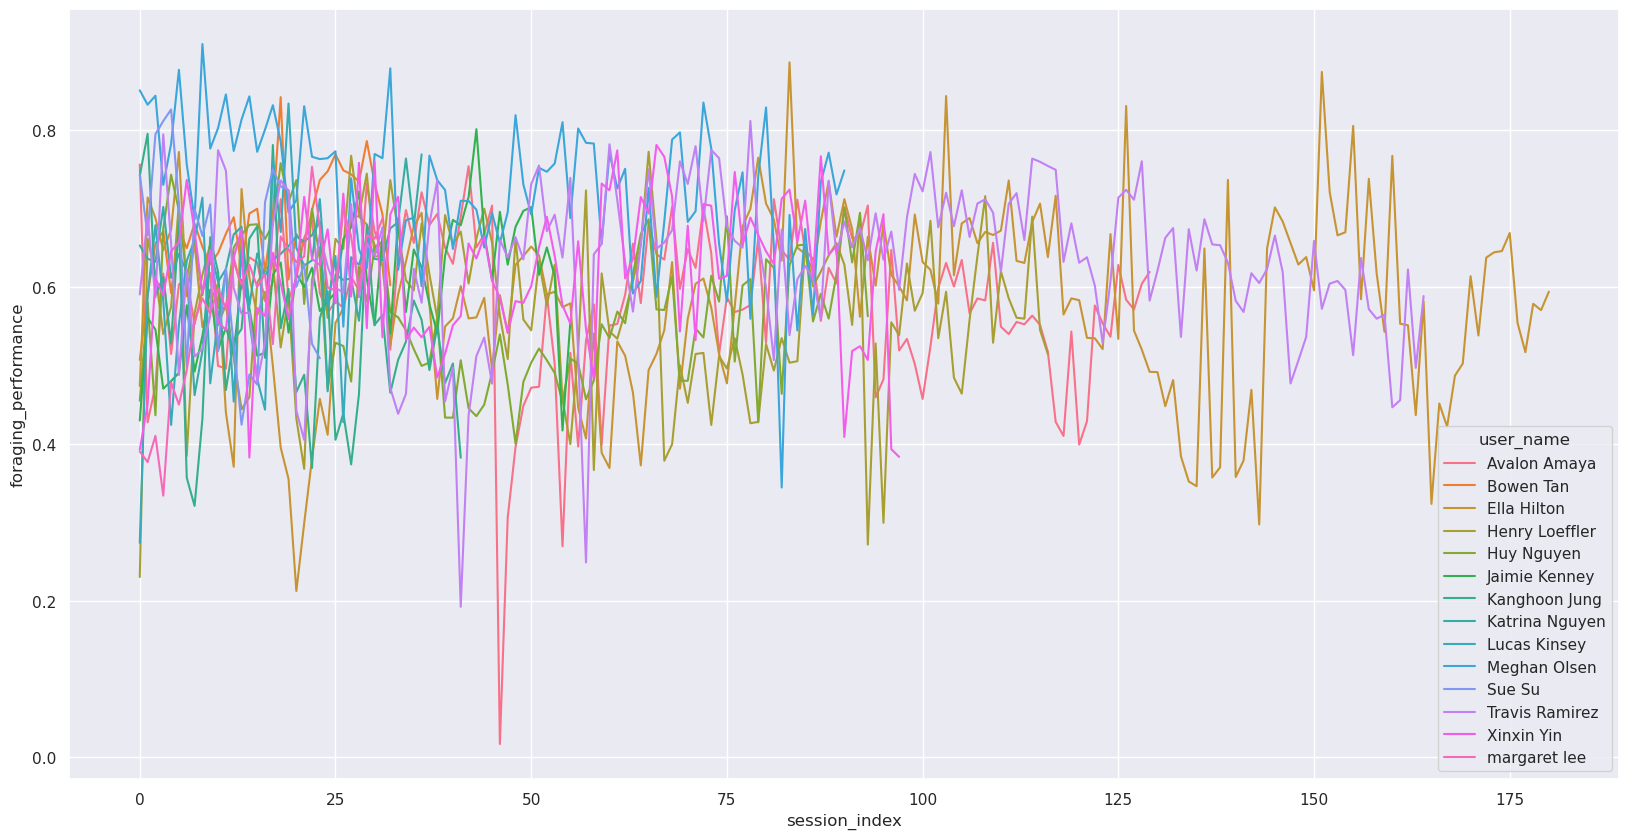

In [70]:
plt.figure(figsize=(20,10))

sns.lineplot(data=filtered_df, x='session_index', y='foraging_performance', hue='user_name')

In [23]:
# Create a function that breaks session indices into day indices

def calc_day_idx(group):
    first_date = group['session_date'].min()
    group['day_index'] = (group['session_date'] - first_date).dt.days + 1
    return group

In [24]:
filtered_df = filtered_df.groupby('user_name').apply(calc_day_idx).reset_index(drop=True)

In [25]:
non_avg_filtered_df = non_avg_filtered_df.groupby('user_name').apply(calc_day_idx).reset_index(drop=True)

In [26]:
# Gap function

def find_gaps(day_idx):
    gaps = []
    for i in range(1, len(day_idx)):
        if day_idx[i] - day_idx[i-1] > a:
            gaps.append((day_idx[i-1], day_idx[i]))
    return gaps

In [27]:
# Set gap prefrence

a = 3

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


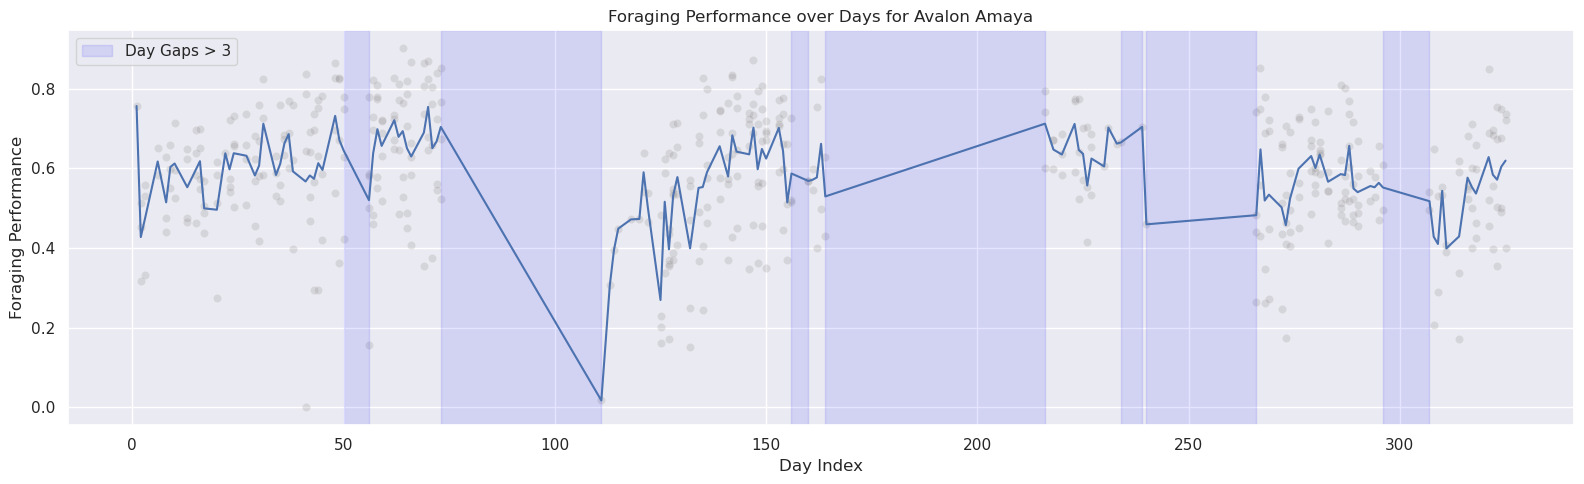

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


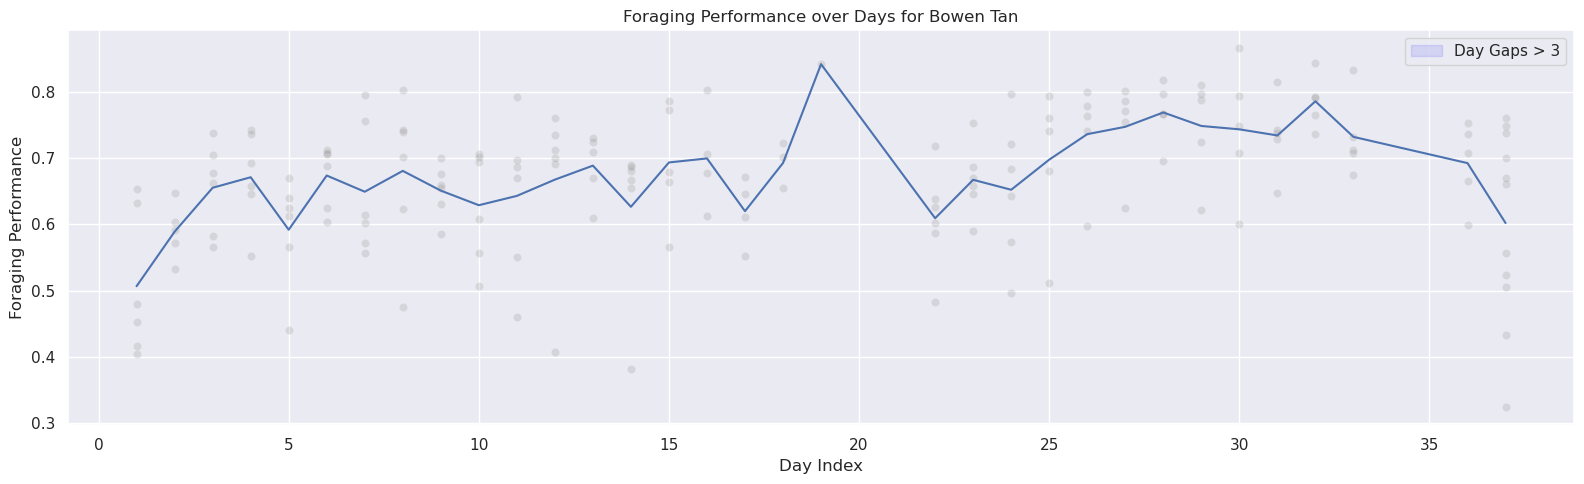

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


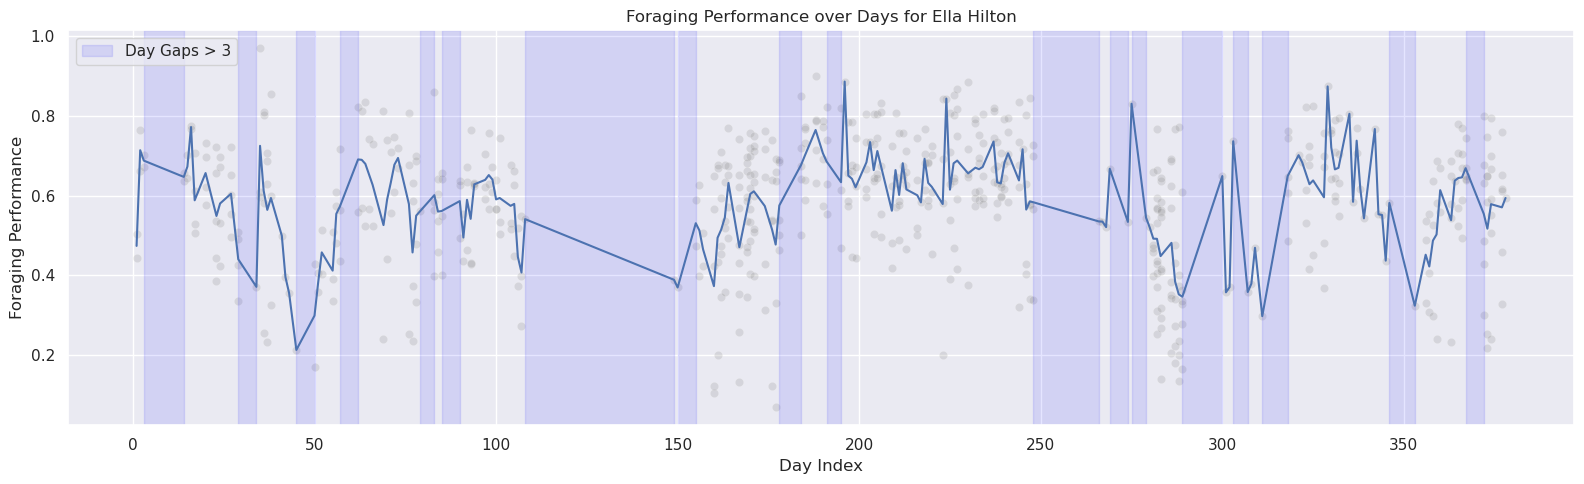

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


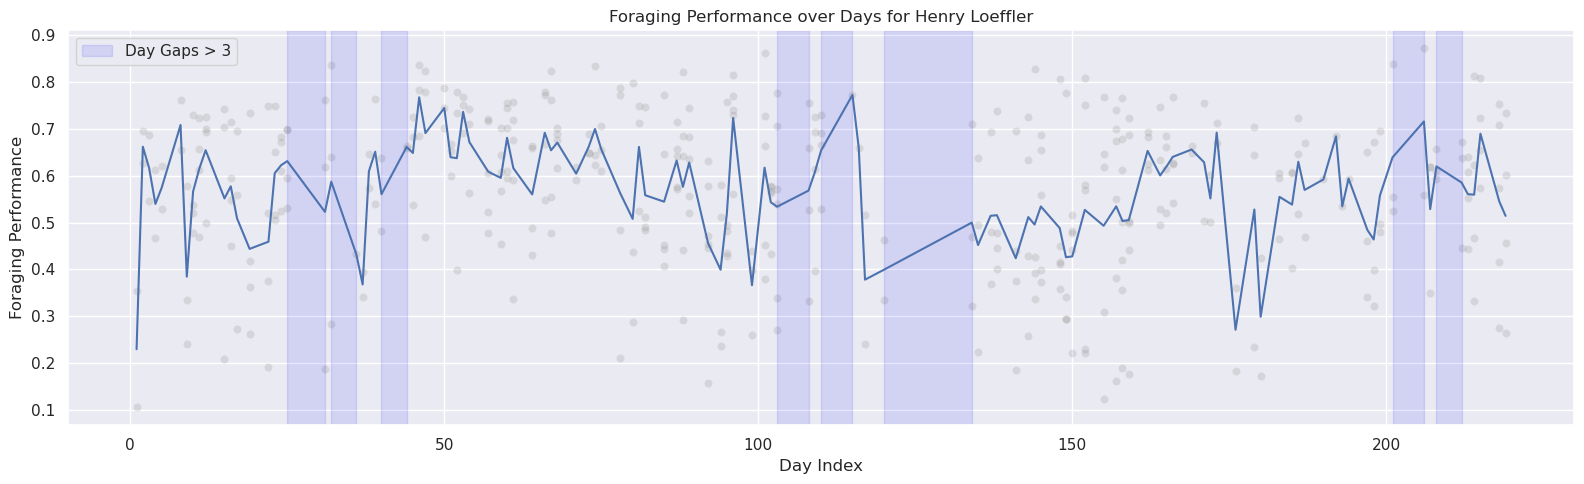

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


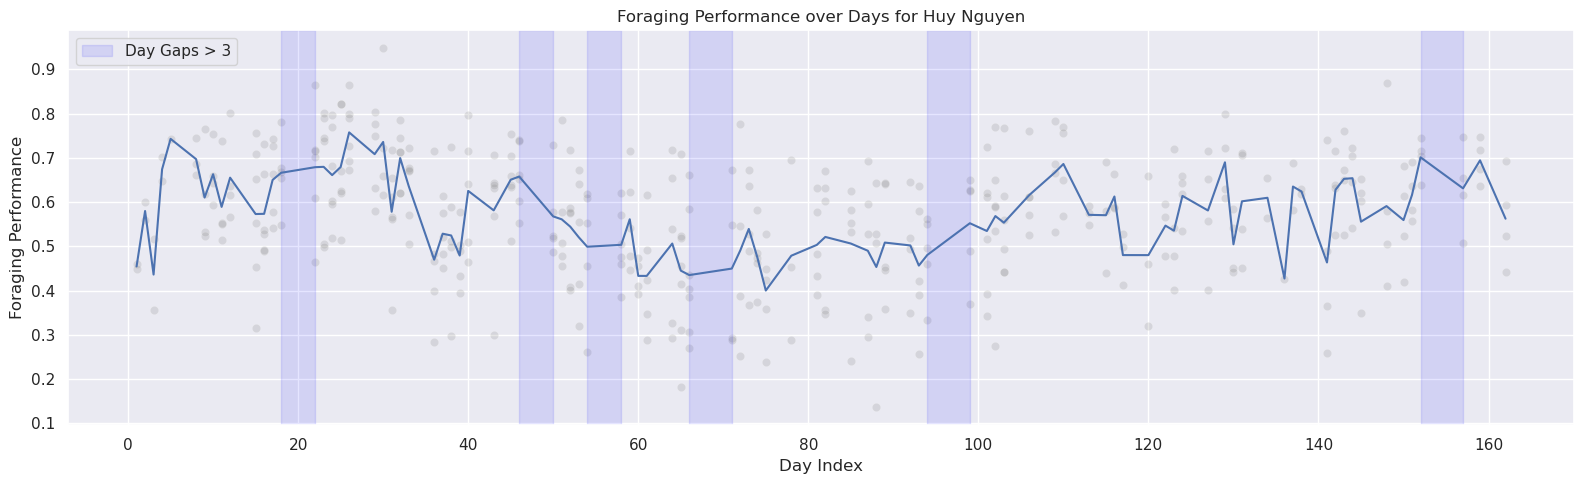

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


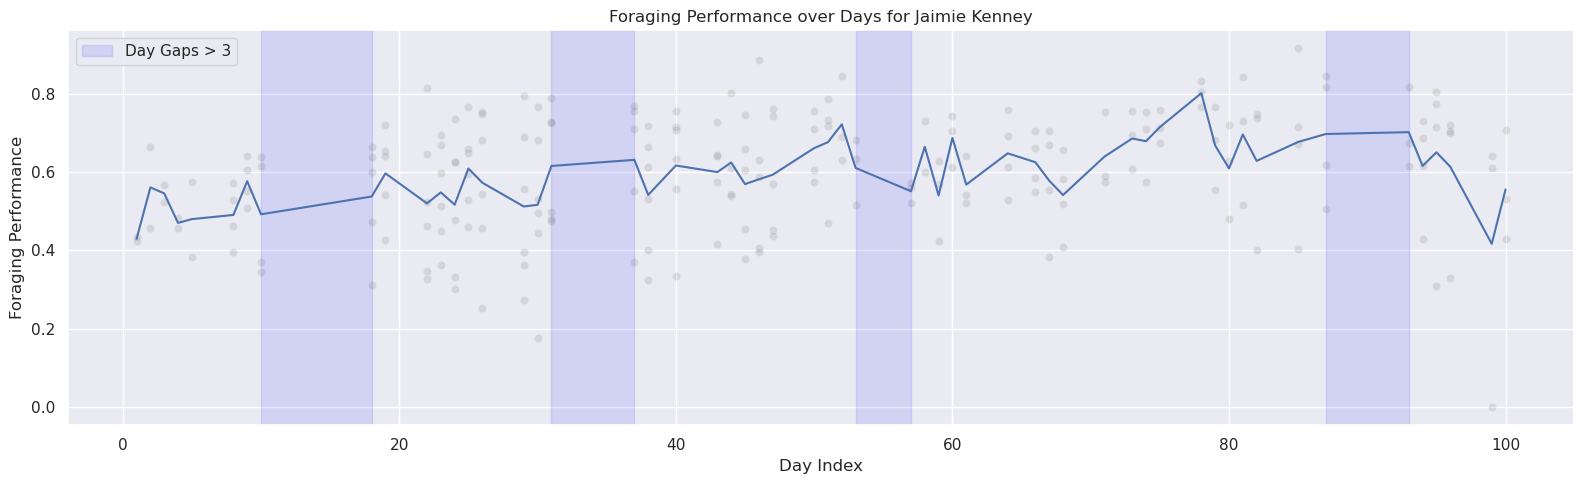

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


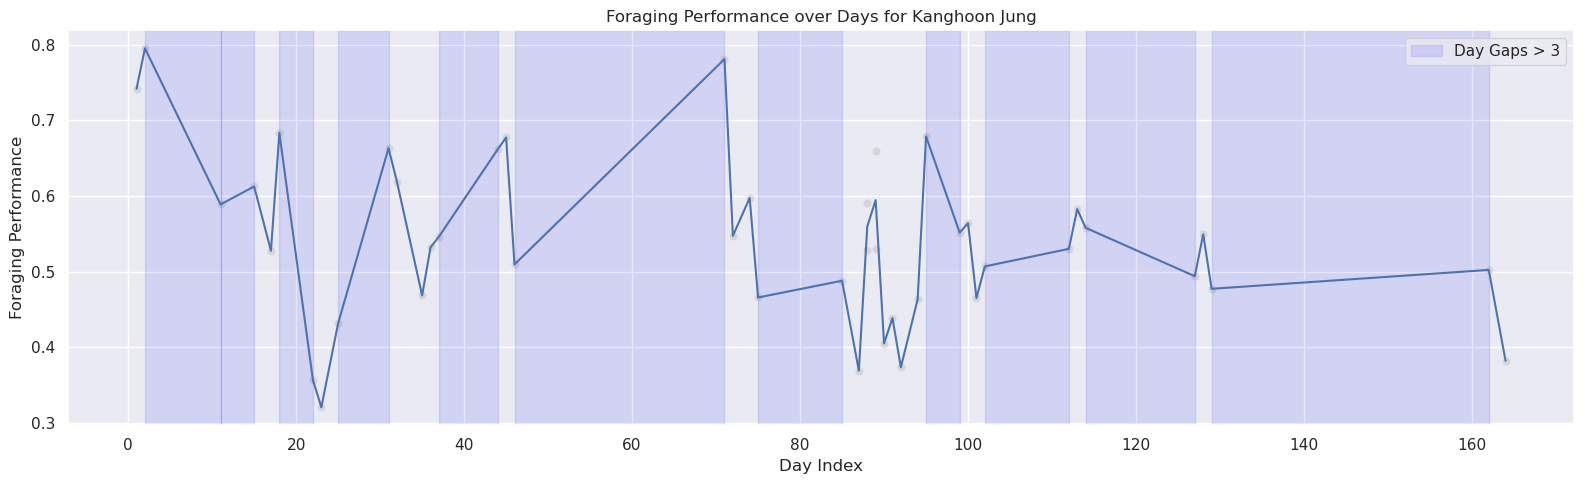

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


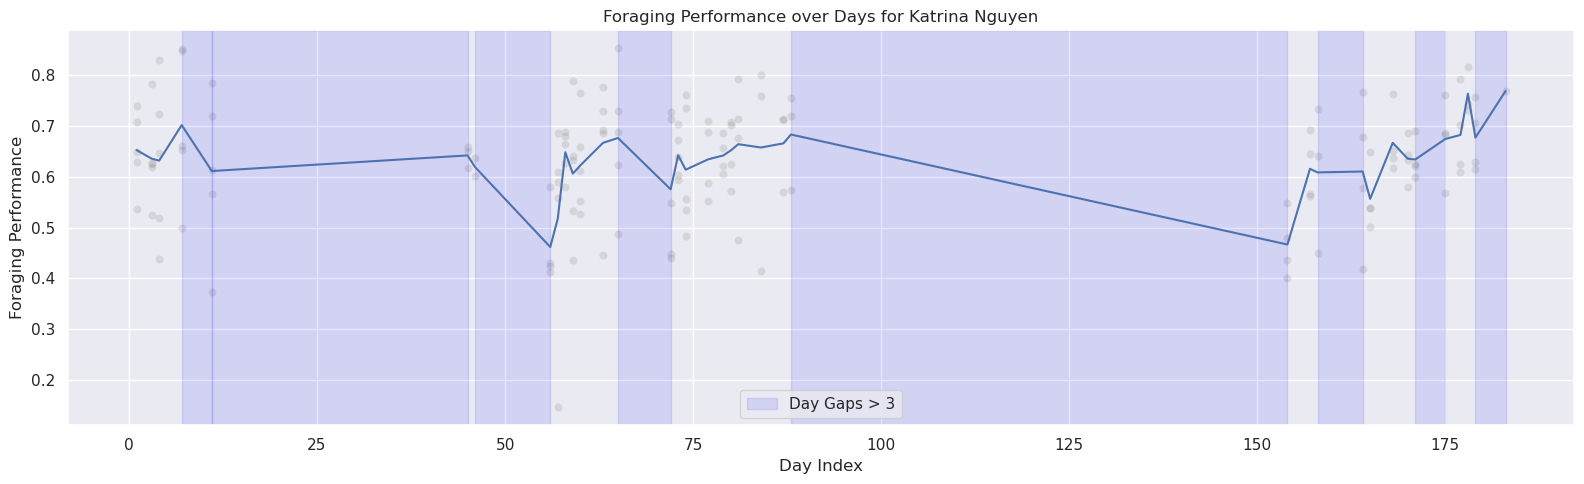

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


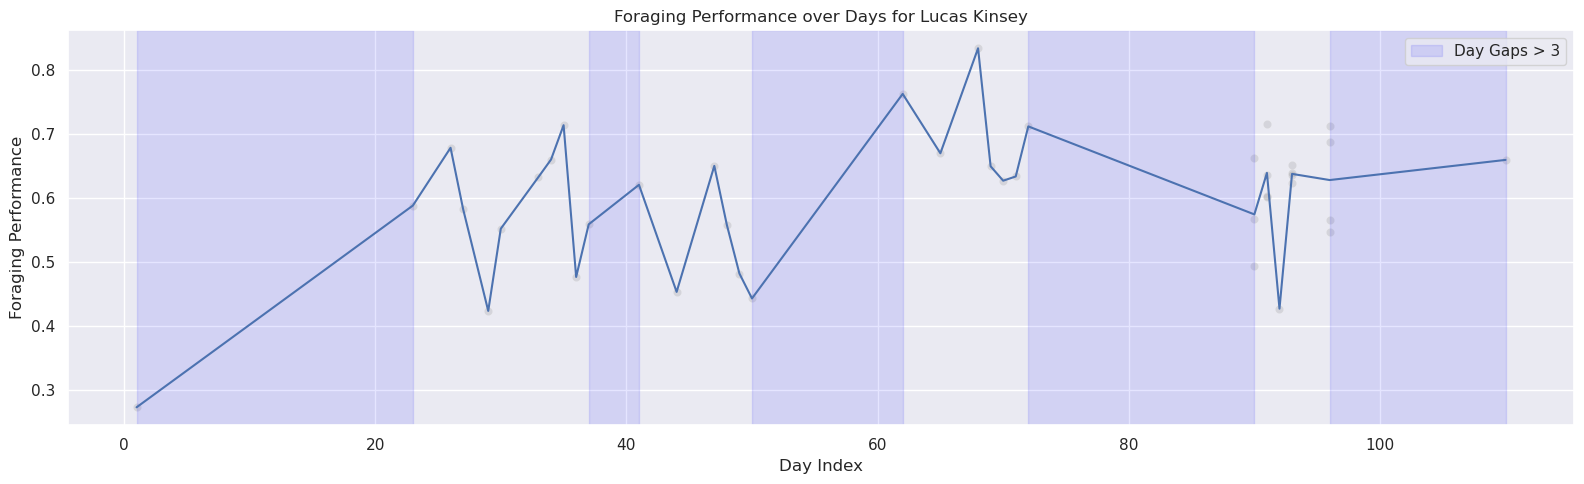

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


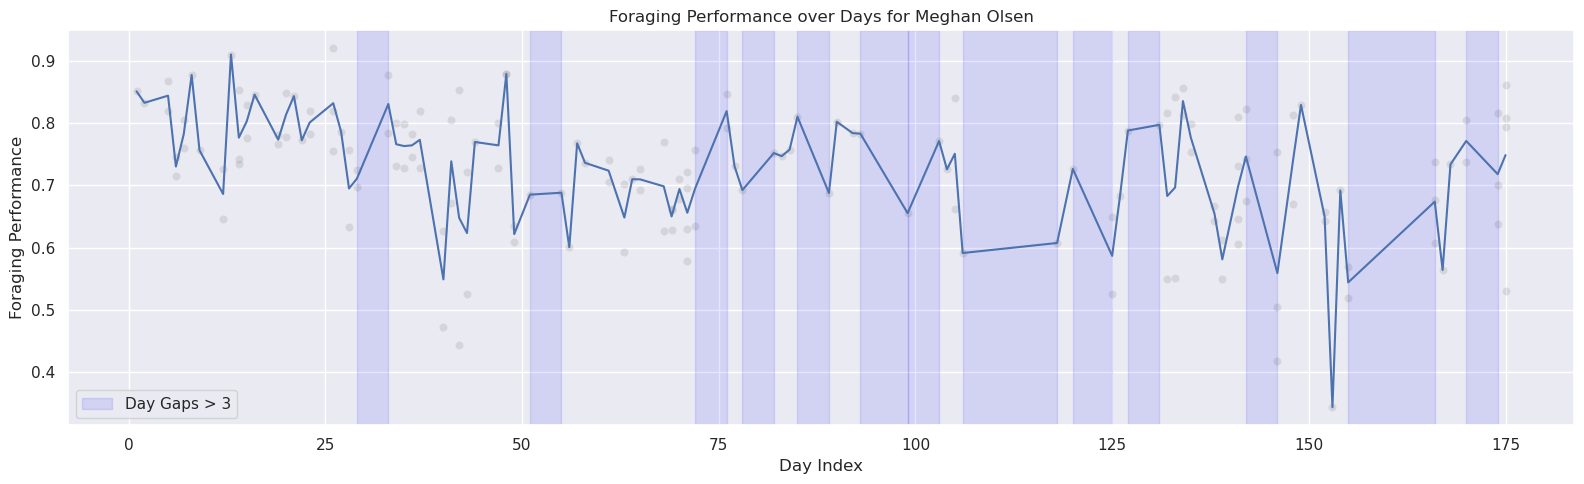

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


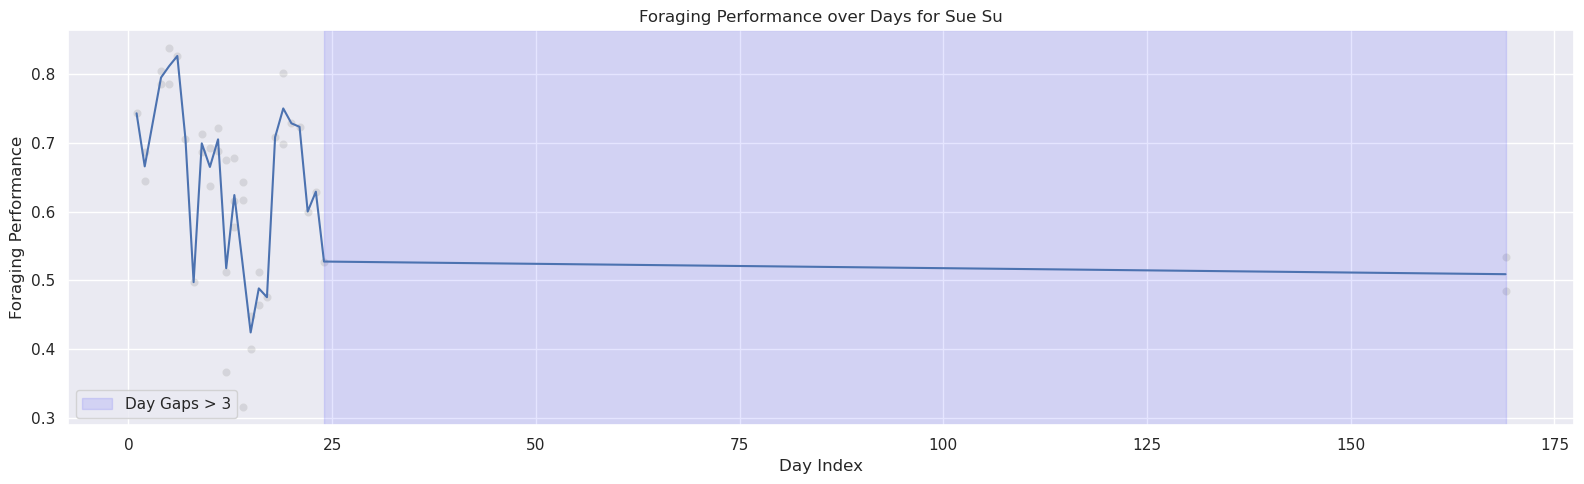

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


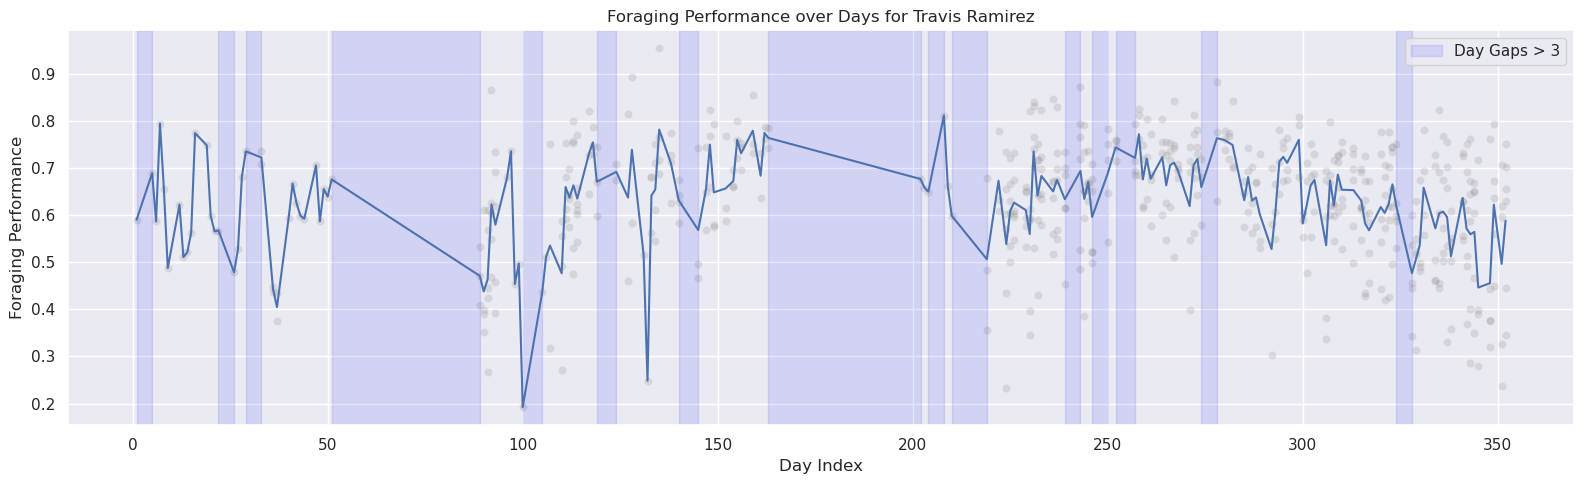

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


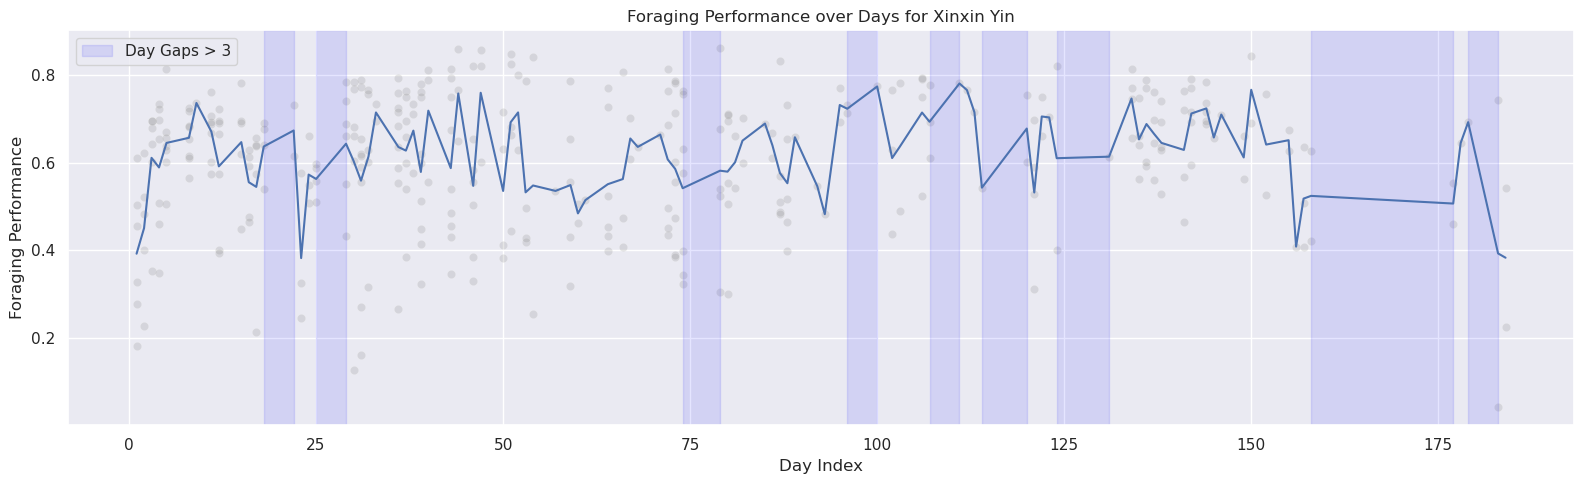

/tmp/ipykernel_6194/2259288569.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax, palette='mako')
/tmp/ipykernel_6194/2259288569.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax, palette='mako')


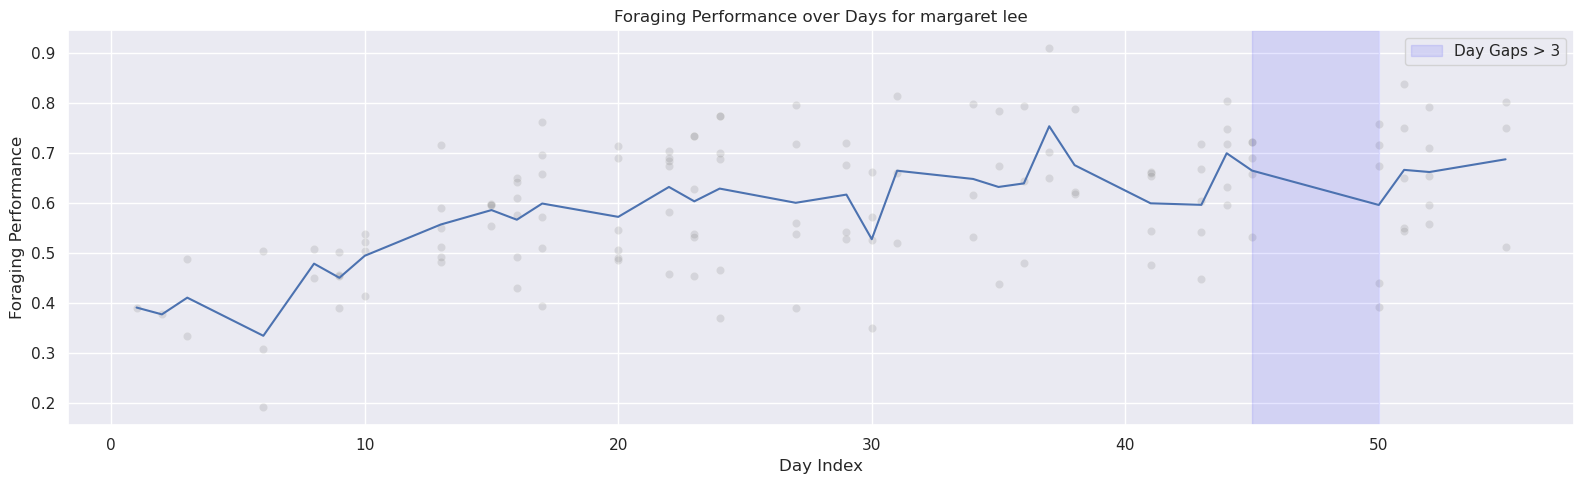

In [60]:
# Plot individual graphs and look for training gaps

users = filtered_df['user_name'].unique()

for user in users: 
    user_data_avg = filtered_df[filtered_df['user_name'] == user]
    user_data_non_avg = non_avg_filtered_df[non_avg_filtered_df['user_name'] == user]

    if len(user_data_avg) or len(user_data_non_avg) >= min_data_pts:


        fig, ax = plt.subplots(figsize=(16,5))
        sns.lineplot(data=user_data_avg, x='day_index', y='foraging_performance', ax=ax)
        sns.scatterplot(data=user_data_non_avg, x='day_index', y='foraging_performance', alpha=0.2, color='grey', legend=False, ax=ax)

        gaps = find_gaps(user_data_avg['day_index'].tolist())

        y_min, y_max = ax.get_ylim()
        for gap_start, gap_end in gaps:
            ax.axvspan(gap_start, gap_end, color='blue', alpha=0.1)

        ax.set_ylim(y_min, y_max)

        plt.title(f'Foraging Performance over Days for {user}')
        plt.xlabel('Day Index')
        plt.ylabel('Foraging Performance')

        ax.fill_between([], [], [], color='blue', alpha=0.1, label=f'Day Gaps > {a}')
        plt.legend()

        plt.tight_layout()

        plt.show()
    else:
        print(f'Skipping plot for {user}: not enough data points: ({len(user_data_avg)} < {min_data_pts})')